In [1]:
from functions import *


import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import math
from skimage.feature import blob_log
from apsg import *

microm2m = 1.0E-6
m2microm = 1.0E6

In [2]:
import pandas as pd

# read data from csv file

data = pd.read_csv('dataframe1.csv', delimiter=',')
data.head()

,Radius (μm),Hc (mT),TRM (A/m),D (°),I (°),Xc (μm),Yc (μm),Zc (μm),mx (Am$^2$),my (Am$^2$),mz (Am$^2$)
0,0.274359,103.133782,49233.801378,45.0,45.0,251,676,1,2.129498e-15,2.129498e-15,3.011565e-15
1,0.248128,117.159881,50420.040450,45.0,45.0,525,549,8,1.613198e-15,1.613198e-15,2.281407e-15
2,0.224965,114.074488,52016.067102,45.0,45.0,546,421,2,1.240343e-15,1.240343e-15,1.754109e-15
3,0.262240,85.659080,51627.093998,45.0,45.0,414,214,9,1.949984e-15,1.949984e-15,2.757694e-15
4,0.316949,100.989428,50513.524641,45.0,45.0,877,367,5,3.368493e-15,3.368493e-15,4.763768e-15


In [3]:
flight = 5.0  # sample-sensor distance
area = (0, 1000*microm2m, 0, 1000*microm2m)
shape = (1000,1000)
z = -flight*microm2m

f = np.matrix(regular(area, shape, z))
X = np.array(f[0])
Y = np.array(f[1])
Z = np.array(f[2])

cm = 10**(-7) # H/m  == T·m/A


# read generated sourcers
index = (data["Hc (mT)"]>=50)
g     =  data[index]


D = np.array(g['D (°)'])
I = np.array(g['I (°)'])
Q = np.array(g['TRM (A/m)'])
R = np.array(g['Radius (μm)'])*microm2m

Xc = np.array(g['Xc (μm)'])*microm2m
Yc = np.array(g['Yc (μm)'])*microm2m
Zc = np.array(g['Zc (μm)'])*microm2m



m = cartesian_components(D, I, Q, R)
M = sensibility_matrix(X, Y, Z, Xc, Yc, Zc)


In [4]:
# data vector direct model
d = np.matmul(M, m)

#apply noise
d = noise(d, error=150.0E-9, method='fixed') # noise of 150 nT with 'fixed' method

# Reshape data vector for the map plot
d_= np.reshape(d, shape)

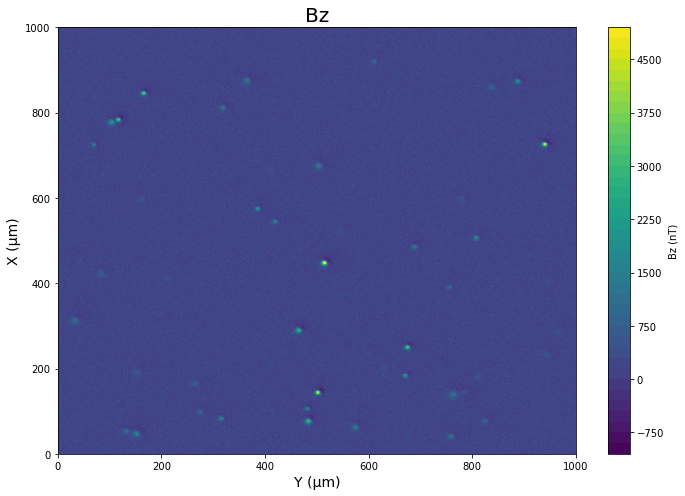

In [5]:
xs = np.linspace(area[0], area[1], shape[0])
ys = np.linspace(area[2], area[3], shape[1])

x_plot = np.reshape(Y,(np.size(xs),np.size(ys)))*m2microm
y_plot = np.reshape(X,(np.size(xs),np.size(ys)))*m2microm

# plot do mapa de dados do modelo direto

plt.figure(figsize=(10, 7))
plt.contourf(x_plot, y_plot, d_*10**9, levels=50, cmap='viridis')
plt.colorbar(label='Bz (nT)')

plt.title('Bz', fontsize=20)
plt.xlabel('Y (µm)', fontsize=14)
plt.ylabel('X (µm)', fontsize=14)

plt.tight_layout()

plt.show()

In [6]:
X_ = np.reshape(X, shape)
Y_ = np.reshape(Y, shape)
Z_ = np.reshape(Z, shape)


# calculating derivatives using Fast Fourier Transform (FFT)

wx, wy, wz = wave_numbers(d_, X_, Y_)

ddx = x_derivative_fft(d_, wx, order=1)
ddy = y_derivative_fft(d_, wy, order=1)
ddz = z_derivative_fft(d_, wz, order=1)

# calculating derivatives (x and y) using Finite Differences (FD)
d_X, d_Y = (derivative_fd(d_, X_,Y_, order=1))


In [7]:
# upward_continuation filtering --> to remove high frequency noise
height = 5.0      # delta_z upward continuation
delta_z = -height*microm2m
upward = upward_continuation(d_, delta_z, wz)


# upward_continuation --> used later to calculate the Z derivative by FD
delta_z1 = -(height-0.1)*microm2m
upward1 = upward_continuation(d_, delta_z1, wz)

delta_z2 = -(height+0.1)*microm2m
upward2 = upward_continuation(d_, delta_z2, wz)

Text(0, 0.5, 'X (µm)')

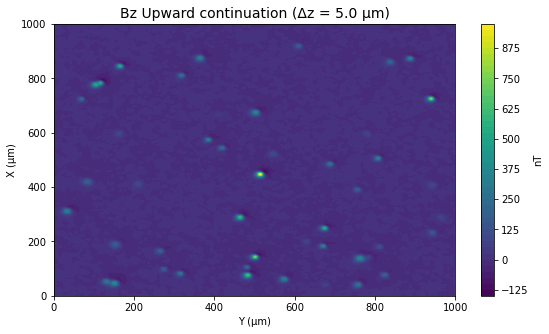

In [8]:
# upward continuation plot

plt.figure(figsize=(9,5))
plt.contourf(x_plot, y_plot, (upward)*10**9, levels=50, cmap='viridis')
plt.colorbar(label='nT')

plt.title('Bz Upward continuation (Δz = %s µm)'%height, fontsize=14)
plt.xlabel('Y (µm)', fontsize=10)
plt.ylabel('X (µm)', fontsize=10)


In [9]:
# Novas derivadas (em x e y) usando a continuação p/ cima por FD
d_X, d_Y = (derivative_fd(upward, X_,Y_))
d_Z = z_derivative_fd(upward1, upward2, delta_z1, delta_z2)

In [10]:
Total_Grad_FD = Total_Grad(d_Y , d_X, d_Z)

Text(0, 0.5, 'X (µm)')

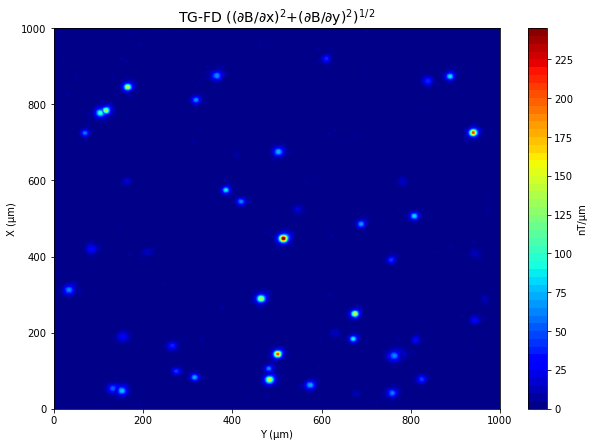

In [11]:
fig, ((ax1)) = plt.subplots(1,1, figsize=(10,7))

# plot FD horizontal gradient 
ax1_plot  = ax1.contourf(x_plot, y_plot, Total_Grad_FD*10**3, levels=50, cmap='jet')
plt.colorbar(ax1_plot, ax=ax1, label='nT/µm')
ax1.set_title('TG-FD'+' ((∂B/∂x)$^2$+(∂B/∂y)$^2$)$^1$$^/$$^2$', fontsize=14)
ax1.set_xlabel('Y (µm)', fontsize=10)
ax1.set_ylabel('X (µm)', fontsize=10)

Text(0, 0.5, 'Count')

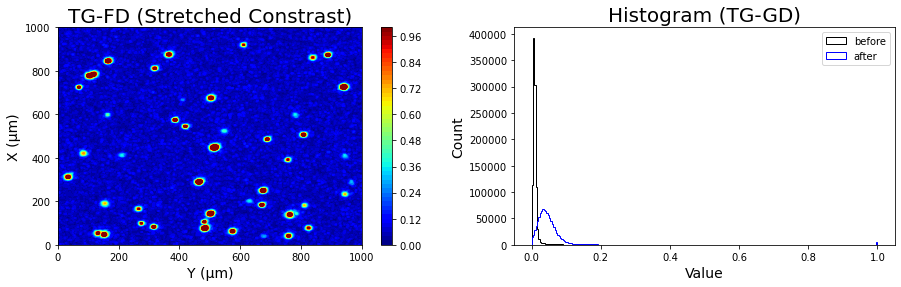

In [12]:
import skimage
import scipy.signal as signal

image =  Total_Grad_FD/Total_Grad_FD.max()

perc_min, perc_max = np.percentile(image, (0.5,99.5))
stretched_image = skimage.exposure.rescale_intensity(image, in_range=(perc_min, perc_max))



fig, ((ax1, ax2)) = plt.subplots(1,2, figsize=(15,4))

ax1_plot = ax1.contourf(x_plot, y_plot, stretched_image, levels=50, cmap='jet')
ax1.set_title('TG-FD (Stretched Constrast)', fontsize=20)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)

plt.colorbar(ax1_plot, ax=ax1)

ax2.hist(image.ravel(), bins=256, histtype='step', color='k', label='before');
ax2.hist(stretched_image.ravel(), bins=256, histtype='step', color='b', label='after');
ax2.legend()
ax2.set_title('Histogram (TG-GD)', fontsize=20)
ax2.set_xlabel('Value', fontsize=14)
ax2.set_ylabel('Count', fontsize=14)


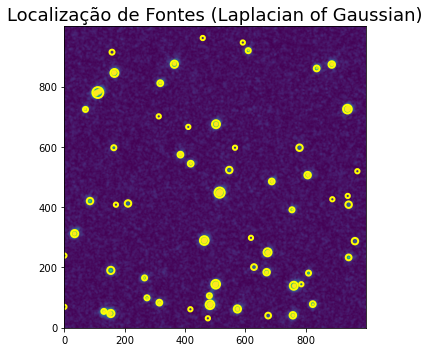

(58, 4)


()

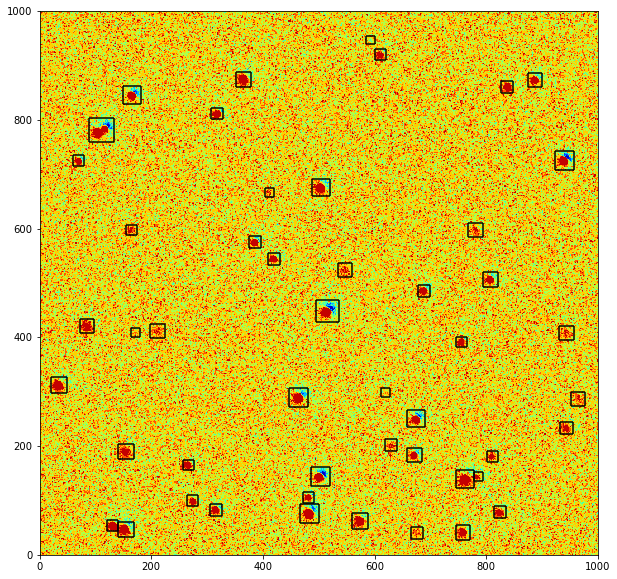

In [13]:
circles_FD, euler_windows_FD = sources_finder(stretched_image, threshold=0.05, min_sigma=5, max_sigma=30, num_sigma=30, overlap=1.0, radius_increment=0.2)
print(np.shape(euler_windows_FD))

Xc_FD, Yc_FD, Zc_FD, filtered_euler_windows_FD = solve_euler_windows(euler_windows_FD, X_, Y_, Z_, upward, d_X, d_Y, d_Z, delta_z, structural_index = 3.0)

import skimage
perc_min, perc_max = np.percentile(d_, (0.5,99.5))
view = skimage.exposure.rescale_intensity(d_, in_range=(perc_min, perc_max))
euler_windows_view(X_, Y_, Z_, view, filtered_euler_windows_FD, show_windows=False, color='k')


Euler Solutions:
    Xc (µm)   Yc (µm)  Zc (µm)
0  448.9687  515.9539   2.1013
1  727.0610  941.0739   1.0829
2  144.6678  503.0080   1.0666
3  251.0359  676.0744   1.1235
4  290.9227  465.8943   3.0806

Original Positions:
   Xc (µm)  Yc (µm)  Zc (µm)
0    251.0    676.0      1.0
1    525.0    549.0      8.0
2    546.0    421.0      2.0
3    414.0    214.0      9.0
4    877.0    367.0      5.0



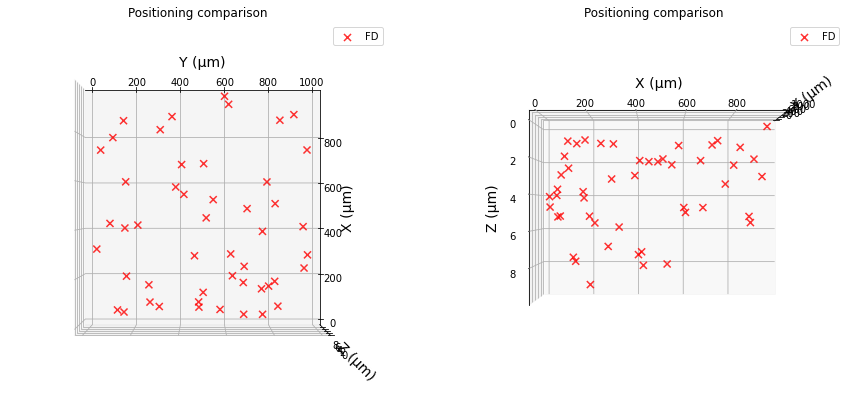

In [14]:
import pandas as pd
print('Euler Solutions:')
df1 = pd.DataFrame(data={'Xc (µm)': (np.round(Xc_FD*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc_FD*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc_FD*m2microm, decimals=4))
                       })

print(df1.head(5))
print()

print('Original Positions:')
df2 = pd.DataFrame(data={
                        'Xc (µm)': (np.round(Xc*m2microm, decimals=4)),
                        'Yc (µm)': (np.round(Yc*m2microm, decimals=4)),
                        'Zc (µm)': (np.round(Zc*m2microm, decimals=4))
                       })

print(df2.head(5))
print()

from mpl_toolkits.mplot3d import axes3d


fig = plt.figure(figsize=(15,15))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')

ax1.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm,
            alpha=0.8, color='r', marker='x', s=50, label='FD')

ax1.set_title('Positioning comparison')
ax1.legend(loc='best')
ax1.invert_zaxis()

ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)
ax1.set_zlabel('Z (µm)', fontsize=14)

ax1.azim = -90
ax1.dist = 10
ax1.elev = 90



ax2.scatter(Yc_FD*m2microm, Xc_FD*m2microm, Zc_FD*m2microm,
            alpha=0.8, color='r', marker='x', s=50, label='FD')

ax2.set_title('Positioning comparison')
ax2.legend(loc='best')
ax2.invert_zaxis()

ax2.set_xlabel('Y (µm)', fontsize=14)
ax2.set_ylabel('X (µm)', fontsize=14)
ax2.set_zlabel('Z (µm)', fontsize=14)

ax2.azim = 0
ax2.dist = 10
ax2.elev = 0

plt.show()

# Magnetic inversion using lest square method


,Dec (°),$\sigma D$ (°),Inc (°),$\sigma I$ (°),m ($A \cdot m^2$),$\sigma m$ ($A \cdot m^2$),Xc (µm),Yc (µm),Zc (µm)
0,45.5677,0.5498,45.9021,0.3331,1.044648e-14,6.009734e-17,448.968710,515.953912,2.101333
1,43.9444,0.6477,43.8892,0.4016,6.282898e-15,4.461396e-17,727.061026,941.073921,1.082862
2,49.0062,0.7416,48.9678,0.4312,5.992099e-15,4.306518e-17,144.667812,503.007979,1.066580
3,45.4192,0.9033,43.6444,0.5616,4.547012e-15,4.527554e-17,251.035920,676.074417,1.123503
4,45.0720,0.9414,46.5227,0.5659,7.989842e-15,7.753072e-17,290.922716,465.894272,3.080606
5,43.2958,0.9239,44.2334,0.5707,4.525858e-15,4.548570e-17,847.026418,167.005126,1.148093
6,8.1792,2.0189,64.2629,0.8343,6.255641e-15,7.378952e-17,783.333631,114.826690,3.318231
7,51.4235,1.6028,45.4542,0.9763,3.489324e-15,5.914287e-17,507.615831,809.174255,2.035477
8,55.4072,1.5764,44.8378,0.9672,2.662402e-15,4.502773e-17,575.601026,387.401972,1.127731
9,40.3335,1.5839,46.3051,0.9547,3.620414e-15,5.941939e-17,875.072847,888.915198,2.069452


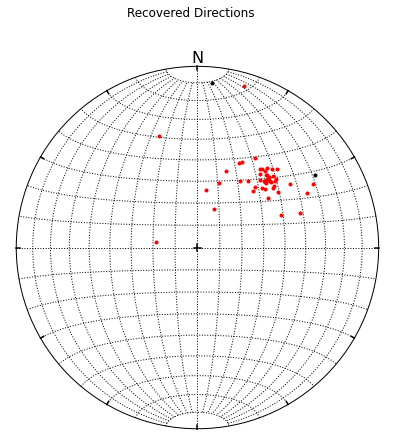

In [15]:
error = 0.05
d = np.squeeze(d)

# Magnetic inversion using FD euler positions and magnetic data before the upward continuation
hx_FD_least, hy_FD_least, hz_FD_least, M_FD_least, direct_model_FD_least = least_square_solver(X, Y, Z, Xc_FD, Yc_FD, Zc_FD, d)
D_FD_least, I_FD_least = directions(hx_FD_least, hy_FD_least, hz_FD_least, plot=True, show_mean=False, show_alpha95=False)


momentum_FD_least = (np.sqrt(hx_FD_least**2 + hy_FD_least**2 + hz_FD_least**2))


#Inversion uncertainties
sigma_noise = (np.absolute(np.max(d))+np.absolute(np.min(d))) * error
sigma_noise = 150*1.0e-9 # noise of 150 nT
sigma_D_FD_least, sigma_I_FD_least, sigma_m_FD_least = uncertainties(sigma_noise, M_FD_least, hx_FD_least, hy_FD_least, hz_FD_least)

import pandas as pd
df = pd.DataFrame(data={'Dec (°)': (np.round(D_FD_least, decimals=4)),
                        '$\sigma D$ (°)':    (np.round(sigma_D_FD_least, decimals=4)),
                        'Inc (°)': (np.round(I_FD_least, decimals=4)),
                        '$\sigma I$ (°)':    (np.round(sigma_I_FD_least, decimals=4)),
                        'm  ($A \cdot m^2$)':  (momentum_FD_least),
                        '$\sigma m$ ($A \cdot m^2$)':  (sigma_m_FD_least),
                        'Xc (µm)': Xc_FD*m2microm,
                        'Yc (µm)': Yc_FD*m2microm,
                        'Zc (µm)': Zc_FD*m2microm
                        
                       })

df.head(-5)



# Direct Model and Errors

### Whole Area

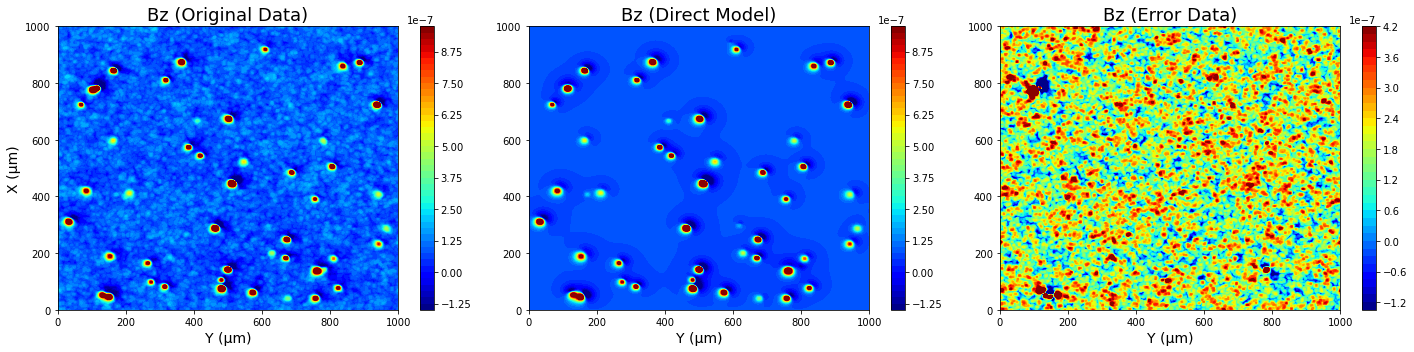

In [16]:
direct_model_FD_least = np.reshape(direct_model_FD_least, shape)

upward_direct_model_FD_least = upward_continuation(direct_model_FD_least, delta_z, wz)

fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

perc_min, perc_max = np.percentile(upward, (0.5,99.5))
original_data_view = skimage.exposure.rescale_intensity(upward, in_range=(perc_min, perc_max))
ax4_plot = ax1.contourf(x_plot, y_plot, upward, levels=50, cmap='jet')
ax1_plot = ax1.contourf(x_plot, y_plot, original_data_view, levels=50, cmap='jet')

plt.colorbar(ax4_plot, ax=ax1)
ax1.set_title('Bz (Original Data)', fontsize=18)
ax1.set_xlabel('Y (µm)', fontsize=14)
ax1.set_ylabel('X (µm)', fontsize=14)


perc_min, perc_max = np.percentile(upward_direct_model_FD_least, (0.5,99.5))
direct_model_view = skimage.exposure.rescale_intensity(upward_direct_model_FD_least, in_range=(perc_min, perc_max))
ax5_plot = ax2.contourf(x_plot, y_plot, upward_direct_model_FD_least, levels=50, cmap='jet')
ax2_plot = ax2.contourf(x_plot, y_plot, direct_model_view, levels=50, cmap='jet')
plt.colorbar(ax5_plot, ax=ax2)
ax2.set_title('Bz (Direct Model)', fontsize=18)
ax2.set_xlabel('Y (µm)', fontsize=14)

error = upward - upward_direct_model_FD_least
perc_min, perc_max = np.percentile(error, (0.5,99.5))
error_data_view = skimage.exposure.rescale_intensity(error, in_range=(perc_min, perc_max))
ax6_plot = ax3.contourf(x_plot, y_plot, error, levels=50, cmap='jet')
ax3_plot = ax3.contourf(x_plot, y_plot, error_data_view, levels=50, cmap='jet')
plt.colorbar(ax6_plot, ax=ax3)
ax3.set_title('Bz (Error Data)', fontsize=18)
ax3.set_xlabel('Y (µm)', fontsize=14)



plt.tight_layout()

#plt.savefig('teste.jpg', dpi=500)

### For each Window

In [17]:
Xc_save, Yc_save, Zc_save = [], [], []
hx_save, hy_save, hz_save = [], [], []
m_save, D_save, I_save = [], [], []
sigma_m_save, sigma_D_save, sigma_I_save = [], [], []
deter_coef_save = []

show=False


for i in range(np.shape(filtered_euler_windows_FD)[0]):
    
    if Zc_FD[i]>=0:
        x1, x2 = int(euler_windows_FD[i,0]), int(euler_windows_FD[i,1])
        y1, y2 = int(euler_windows_FD[i,2]), int(euler_windows_FD[i,3])

        data_normalized = upward[x1:x2, y1:y2]/(np.absolute(np.max(upward[x1:x2, y1:y2])
                                                         -np.min(upward[x1:x2, y1:y2])))

        model_normalized = (upward_direct_model_FD_least[x1:x2, y1:y2]/
                            (np.absolute(np.max(upward_direct_model_FD_least[x1:x2, y1:y2])
                            -np.min(upward_direct_model_FD_least[x1:x2, y1:y2]))) )

        error_normalized = data_normalized-model_normalized

        SQ_tot = np.sum( (data_normalized-np.mean(data_normalized))**2 )
        SQ_res = np.sum( (data_normalized-model_normalized)**2 )
        deter_coef = 1 - (SQ_res/SQ_tot)
        

        momentum = (np.sqrt(hx_FD_least[i]**2 + hy_FD_least[i]**2 + hz_FD_least[i]**2))
        Xc_save.append(Xc_FD[i]*m2microm)
        Yc_save.append(Yc_FD[i]*m2microm)
        Zc_save.append(Zc_FD[i]*m2microm)
        hx_save.append(hx_FD_least[i])
        hy_save.append(hy_FD_least[i])
        hz_save.append(hz_FD_least[i])
        m_save.append(momentum)
        sigma_m_save.append(sigma_m_FD_least[i])
        D_save.append(D_FD_least[i])
        sigma_D_save.append(sigma_D_FD_least[i])
        I_save.append(I_FD_least[i])
        sigma_I_save.append(sigma_I_FD_least[i])
        deter_coef_save.append(deter_coef)

        if show:

            fig, ((ax1, ax2, ax3)) = plt.subplots(1,3, figsize=(20,5))

            ax1_plot = ax1.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax1_plot, ax=ax1)
            ax1.set_title('Bz (Original Data)', fontsize=18)
            ax1.set_xlabel('Y (µm)', fontsize=14)
            ax1.set_ylabel('X (µm)', fontsize=14)


            ax2_plot = ax2.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], 
                                    upward_direct_model_FD_least[x1:x2, y1:y2], levels=50, cmap='viridis')
            plt.colorbar(ax2_plot, ax=ax2)
            ax2.set_title('Bz (Direct Model)', fontsize=18)
            ax2.set_xlabel('Y (µm)', fontsize=14)

            error = upward[x1:x2, y1:y2] - upward_direct_model_FD_least[x1:x2, y1:y2]
            ax3_plot = ax3.contourf(x_plot[x1:x2, y1:y2], y_plot[x1:x2, y1:y2], error, levels=50, cmap='viridis')
            plt.colorbar(ax3_plot, ax=ax3)
            ax3.set_title('Bz (Error Data)', fontsize=18)
            ax3.set_xlabel('Y (µm)', fontsize=14)

            plt.tight_layout()
            plt.show()

                    
df_final = pd.DataFrame(data={'Xc (µm)': np.array(np.round(Xc_save, decimals=4)),
                              'Yc (µm)': np.array(np.round(Yc_save, decimals=4)),
                              'Zc (µm)': np.array(np.round(Zc_save, decimals=4)),
                              'mx (Am2)': np.array(hx_save),
                              'my (Am2)': np.array(hy_save),
                              'mz (Am2)': np.array(hz_save),
                              'm (Am2)': np.array(m_save),
                              'sigma m (Am2)': np.array(sigma_m_save),
                              'D (°)': np.array(D_save),
                              'sigma D (°)': np.array(sigma_D_save),
                              'I (°)': np.array(I_save),
                              'sigma I (°)': np.array(sigma_I_save),
                              'R2': np.array(deter_coef_save)

                       })

In [18]:
df_final.head(-5)
display(df_final)

,Xc (µm),Yc (µm),Zc (µm),mx (Am2),my (Am2),mz (Am2),m (Am2),sigma m (Am2),D (°),sigma D (°),I (°),sigma I (°),R2
0,448.9687,515.9539,2.1013,5.089166e-15,5.191037e-15,7.502165e-15,1.044648e-14,6.009734e-17,45.567748,0.549832,45.902149,0.333093,0.999569
1,727.0610,941.0739,1.0829,3.260203e-15,3.142230e-15,4.355717e-15,6.282898e-15,4.461396e-17,43.944369,0.647694,43.889176,0.401626,0.997588
2,144.6678,503.0080,1.0666,2.580424e-15,2.969091e-15,4.520084e-15,5.992099e-15,4.306518e-17,49.006234,0.741562,48.967798,0.431192,0.998073
3,251.0359,676.0744,1.1235,2.309568e-15,2.343613e-15,3.138261e-15,4.547012e-15,4.527554e-17,45.419195,0.903259,43.644444,0.561581,0.998805
4,290.9227,465.8943,3.0806,3.882466e-15,3.892235e-15,5.797804e-15,7.989842e-15,7.753072e-17,45.071995,0.941405,46.522694,0.565913,0.999276
5,847.0264,167.0051,1.1481,2.360180e-15,2.223798e-15,3.157161e-15,4.525858e-15,4.548570e-17,43.295842,0.923887,44.233397,0.570720,0.999091
6,783.3336,114.8267,3.3182,2.688834e-15,3.864708e-16,5.635056e-15,6.255641e-15,7.378952e-17,8.179205,2.018904,64.262886,0.834343,0.504328
7,507.6158,809.1743,2.0355,1.526276e-15,1.913545e-15,2.486807e-15,3.489324e-15,5.914287e-17,51.423540,1.602836,45.454218,0.976290,0.995403
8,575.6010,387.4020,1.1277,1.071851e-15,1.554154e-15,1.877266e-15,2.662402e-15,4.502773e-17,55.407187,1.576444,44.837797,0.967184,0.992197
9,875.0728,888.9152,2.0695,1.906521e-15,1.618767e-15,2.617665e-15,3.620414e-15,5.941939e-17,40.333547,1.583900,46.305139,0.954743,0.997646


### Filtering data by: deternation coef. (R$^2$), $\sigma$D and $\sigma$I 

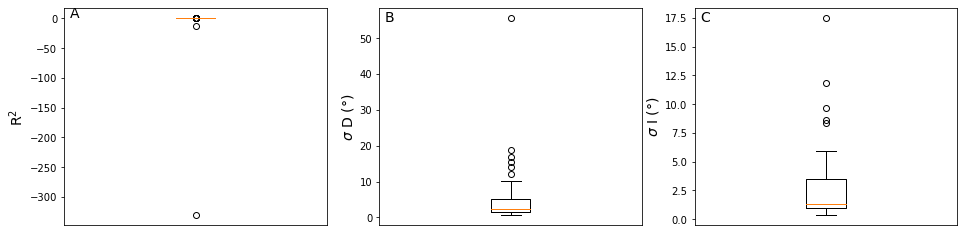

In [19]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
axes[0].boxplot(df_final['R2'])
axes[0].set_xticks([])
axes[0].set_ylabel('R$^2$', fontsize=14)
ytext = df_final['R2'].max()
axes[0].text(0.52, ytext-0.02*ytext, 'A', fontsize=14)

axes[1].boxplot(df_final['sigma D (°)'])
axes[1].set_xticks([])
axes[1].set_ylabel('$\sigma$ D (°)', fontsize=14)
ytext = df_final['sigma D (°)'].max()
axes[1].text(0.52, ytext-0.02*ytext, 'B', fontsize=14)

axes[2].boxplot(df_final['sigma I (°)'])
axes[2].set_xticks([])
axes[2].set_ylabel('$\sigma$ I (°)', fontsize=14)
ytext = df_final['sigma I (°)'].max()
axes[2].text(0.52, ytext-0.02*ytext, 'C', fontsize=14)

plt.show()

#### Directions Recoverd

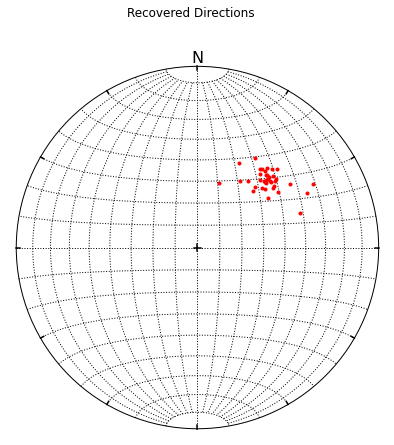

In [22]:
index = ((df_final['R2']>=0.9) & (df_final['sigma D (°)']<=10) & (df_final['sigma I (°)']<=7))
h=df_final[index]


D, I = directions(np.array(h['mx (Am2)']), np.array(h['my (Am2)']), np.array(h['mz (Am2)']), plot=True, show_mean=False, show_alpha95=False)

#### Momentum Recoverd

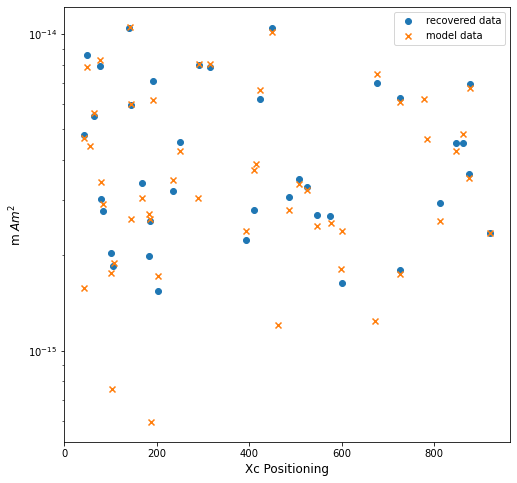

In [23]:
plt.figure(figsize=(8,8))
plt.scatter(h['Xc (µm)'], h['m (Am2)'], label='recovered data')

m_real = Q*4/3*np.pi*R**3
plt.scatter(Xc*m2microm, m_real, marker='x', label='model data')
plt.yscale('log')

plt.xlabel('Xc Positioning', fontsize=12)
plt.ylabel('m $Am^{2}$', fontsize=12)

plt.legend(loc='best')